# Analysis of Zero-one law for Graph Neural Networks

In this project, we aim to deepen the analysis of the paper ``Zero-One Laws of Graph Neural Networks``, Adam-Day et al.

We conduct multiple experiments to witness the zero-one behaviour with various models or hyperparameters.

## Set up

In [1]:
!python -c "import torch; print(torch.__version__)"

2.1.0+cu121


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GINConv
from torch_geometric.nn.conv import GatedGraphConv
from torch_geometric import utils

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive

from typing import Callable

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# set up drive for image download
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Images'

Mounted at /content/gdrive


## Models

Let us first introduce models that will be used in the experiments of the study.

Each Graph Neural Network is followed by a Feed-Forward Neural Network (MLP) which outputs a probability of the input being positive.\newline

- Graph Convolutional Network (GCN):
  $\forall u \in V_G, h_u^{(t)} = \text{MLP}^{(t)}\Big(W_1^{(t)} h_u^{(t-1)} + \sum\limits_{v \in N(u)} W_2^{(t)}h_v^{(t-1)}\Big)$

- Graph Neural Network with Mean Aggregation and Global Readout (MeanGNN):
  $\forall u \in V_G, h_u^{(t)} = \text{MLP}^{(t)}\Big( \frac{1}{\lvert N(u) \cup \{u \} \rvert} \sum\limits_{v \in N(u) \cup (u)} W_1 h_v ^{(t-1)} + \frac{1}{\lvert V_G\rvert} \sum\limits_{v \in V_G} W_2 h_v^{(t-1)}\Big)$.
- Graph Neural Network with Sum Aggregation and Global Readout (SumGNN):
  $\forall u \in V_G, h_u^{(t)} = \text{MLP}^{(t)}\Big( W_1 h_u^{(t-1)} + \sum\limits_{v \in N(u) \cup (u)} W_2 h_v ^{(t-1)} + \sum\limits_{v \in V_G} W_3 h_v^{(t-1)}\Big)$.
- Graph Attention Network (GAT):
  $\forall u \in V_G, h_u^{(t)} = \text{MLP} ^{(t)}\Big(W^{(t)} \sum\limits_{v \in N(u) \cup (u)} \alpha (u, v) h_v^{(t-1)}\Big)$, where $\alpha (u,v) = \frac{\exp(e_{u,v})}{\sum\limits_{v'} \exp(e_{u, v})}$.
- Graph Isomorphism Network (GIN):
  $\forall u \in V_G, h_u^{(t)} = \text{MLP}_1^{(t)} \Big( (1 + \varepsilon) \text{MLP}_2^{(t)}(h_u^{(t-1)}) + \sum_{v \in N(u)} \text{MLP}_2^{(t)}(h_v^{(t-1)}) \Big)$.


In [6]:
def to_dense_adj(X, A):
  """
  Converts a set of pairs of nodes to a dense adjacency matrix, taking into account the number of nodes
  (in case the last node is isolated).
  """
  adj_matrix = torch.zeros((len(X), len(X)))
  A_ = utils.to_dense_adj(A)[0]
  adj_matrix[:len(A_), :len(A_)] = A_
  return adj_matrix

In [7]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      output_dim: int,
      n_graph_layers: int,
      n_linear_layers: int,
      act_graph_fn: Callable =F.relu,
      act_linear_fn: Callable =F.relu,
      pooling_fn: str ='mean'):
    """
    Graph Convolutional Network, which includes a self-loop
    """
    super(GCN, self).__init__()
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.output_dim = output_dim
    self.n_graph_layers = n_graph_layers
    self.n_linear_layers = n_linear_layers
    self.act_graph_fn = act_graph_fn
    self.act_linear_fn = act_linear_fn
    self.pooling_fn = pooling_fn
    self.graph_layers = nn.ModuleList([GCNConv(input_dim, hid_dim),
                                    *[GCNConv(hid_dim, hid_dim)]*max(0, n_graph_layers-2),
                                    GCNConv(hid_dim, hid_dim)])
    self.linear_layers = nn.ModuleList([nn.Linear(hid_dim, hid_dim),
                                      *[nn.Linear(hid_dim, hid_dim)]*max(0, n_linear_layers-2),
                                      nn.Linear(hid_dim, output_dim)])

  def forward(self, X, A, intermediate_res=True) -> torch.Tensor:
    for layer in self.graph_layers:
        X = layer(X, A)
        X = self.act_graph_fn(X)
    if self.pooling_fn == 'mean':
        X = X.mean(axis=0)
    if self.pooling_fn == 'sum':
        X = X.sum(axis=0)
    if self.pooling_fn == 'max':
        X = torch.max(X, axis=0).values
    interm_res = X.clone()
    if len(X.shape) == 1:
      X = X.unsqueeze(0)
    for layer in self.linear_layers:
          X = layer(X)
          X = self.act_linear_fn(X)
    if intermediate_res:
      return torch.sigmoid(X), interm_res
    return torch.sigmoid(X)

  def param_init(self):
    for layer in self.graph_layers:
        layer.reset_parameters()
    for layer in self.linear_layers:
        nn.init.xavier_uniform_(layer.weight)
        nn.init.constant_(layer.bias.data, 0.0)

In [8]:
class MeanGNNLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        global_readout: bool = True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_neighbours = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        if global_readout:
            self.weight_readout = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        else:
            self.weight_readout = torch.zeros((input_dim, output_dim)).to(device)
        self.bias = torch.zeros(output_dim).to(device)

    def reset_parameters(self):
        self.weight_neighbours = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        self.weight_readout = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        self.bias = torch.zeros(self.output_dim).to(device)

    def forward(self, X, A):
        A_ = A.clone()
        A_.fill_diagonal_(1)
        neighbours = A_.sum(axis=0)
        neighbours[neighbours != 0] = 1/(neighbours[neighbours != 0])
        neighbours[neighbours == 0] = 0
        X_neighbours = torch.matmul(torch.matmul(torch.matmul(torch.diag(neighbours), A_), X), self.weight_neighbours)
        X_readout = torch.matmul(torch.matmul(torch.eye(len(X)).to(device), X), self.weight_readout)/len(X)
        return X_neighbours + X_readout + self.bias


class MeanGNN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      output_dim: int,
      n_graph_layers: int,
      n_linear_layers: int,
      act_graph_fn: Callable =F.relu,
      act_linear_fn: Callable =F.relu,
      pooling_fn: str ='mean'):
    """
    Graph Convolutional Network, which includes a self-loop
    """
    super(MeanGNN, self).__init__()
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.output_dim = output_dim
    self.n_graph_layers = n_graph_layers
    self.n_linear_layers = n_linear_layers
    self.act_graph_fn = act_graph_fn
    self.act_linear_fn = act_linear_fn
    self.pooling_fn = pooling_fn
    self.graph_layers = nn.ModuleList([MeanGNNLayer(input_dim, hid_dim),
                                    *[MeanGNNLayer(hid_dim, hid_dim)]*max(0, n_graph_layers-2),
                                    MeanGNNLayer(hid_dim, hid_dim)])
    self.linear_layers = nn.ModuleList([nn.Linear(hid_dim, hid_dim),
                                      *[nn.Linear(hid_dim, hid_dim)]*max(0, n_linear_layers-2),
                                      nn.Linear(hid_dim, output_dim)])

    self.param_init()

  def forward(self, X, A, intermediate_res=True) -> torch.Tensor:
    A = to_dense_adj(X, A).to(device)
    for layer in self.graph_layers:
        X = layer(X, A)
        X = self.act_graph_fn(X)
    if self.pooling_fn == 'mean':
        X = X.mean(axis=0)
    if self.pooling_fn == 'sum':
        X = X.sum(axis=0)
    if self.pooling_fn == 'max':
        X = torch.max(X, axis=0).values
    interm_res = X.clone()
    for layer in self.linear_layers:
          X = layer(X)
          X = self.act_linear_fn(X)
    if intermediate_res:
      return torch.sigmoid(X), interm_res
    return torch.sigmoid(X)

  def param_init(self):
    for layer in self.graph_layers:
        layer.reset_parameters()
    for layer in self.linear_layers:
        nn.init.xavier_uniform_(layer.weight)
        nn.init.constant_(layer.bias.data, 0.0)

In [9]:
class SumGNNLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        global_readout: bool = True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_self = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        self.weight_neighbours = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        if global_readout:
            self.weight_readout = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        else:
            self.weight_readout = torch.zeros((input_dim, output_dim)).to(device)
        self.bias = torch.zeros(output_dim).to(device)

    def reset_parameters(self):
        self.weight_self = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        self.weight_neighbours = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        self.weight_readout = (-2 * torch.rand(self.input_dim, self.output_dim) + 1).to(device)
        self.bias = torch.zeros(self.output_dim).to(device)

    def forward(self, X, A):
        X_self = torch.matmul(torch.matmul(torch.eye(len(X)).to(device), X), self.weight_self)
        X_neighbours = torch.matmul(torch.matmul(A, X), self.weight_neighbours)
        X_readout = torch.matmul(X, self.weight_readout)/len(X)
        return X_self + X_neighbours + X_readout + self.bias


class SumGNN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      output_dim: int,
      n_graph_layers: int,
      n_linear_layers: int,
      act_graph_fn: Callable =F.relu,
      act_linear_fn: Callable =F.relu,
      pooling_fn: str ='mean'):
    """
    Graph Convolutional Network, which includes a self-loop
    """
    super(SumGNN, self).__init__()
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.output_dim = output_dim
    self.n_graph_layers = n_graph_layers
    self.n_linear_layers = n_linear_layers
    self.act_graph_fn = act_graph_fn
    self.act_linear_fn = act_linear_fn
    self.pooling_fn = pooling_fn
    self.graph_layers = nn.ModuleList([SumGNNLayer(input_dim, hid_dim),
                                    *[SumGNNLayer(hid_dim, hid_dim)]*max(0, n_graph_layers-2),
                                    SumGNNLayer(hid_dim, hid_dim)])
    self.linear_layers = nn.ModuleList([nn.Linear(hid_dim, hid_dim),
                                      *[nn.Linear(hid_dim, hid_dim)]*max(0, n_linear_layers-2),
                                      nn.Linear(hid_dim, output_dim)])

    self.param_init()

  def forward(self, X, A, intermediate_res=True) -> torch.Tensor:
    A = to_dense_adj(X, A)
    for layer in self.graph_layers:
        X = layer(X, A)
        X = self.act_graph_fn(X)
    if self.pooling_fn == 'mean':
        X = X.mean(axis=0)
    if self.pooling_fn == 'sum':
        X = X.sum(axis=0)
    if self.pooling_fn == 'max':
        X = torch.max(X, axis=0).values
    interm_res = X.clone()
    for layer in self.linear_layers:
          X = layer(X)
          X = self.act_linear_fn(X)
    if intermediate_res:
      return torch.sigmoid(X), interm_res
    return torch.sigmoid(X)

  def param_init(self):
    for layer in self.graph_layers:
        layer.reset_parameters()
    for layer in self.linear_layers:
        nn.init.xavier_uniform_(layer.weight)
        nn.init.constant_(layer.bias.data, 0.0)

In [10]:
class GAT(nn.Module):
    def __init__(self,
                input_dim: int,
                hid_dim: int,
                output_dim: int,
                n_graph_layers: int,
                n_linear_layers: int,
                act_graph_fn: int =F.relu,
                act_linear_fn: int =F.relu,
                pooling_fn: str ='mean'):
      super().__init__()
      self.input_dim = input_dim
      self.hid_dim = hid_dim
      self.output_dm = output_dim
      self.act_graph_fn = act_graph_fn
      self.act_linear_fn = act_linear_fn
      self.pooling_fn = pooling_fn
      self.graph_layers = nn.ModuleList([GATConv(input_dim, hid_dim),
                                        *[GATConv(hid_dim, hid_dim)]*max(0, n_graph_layers-2),
                                        GATConv(hid_dim, hid_dim)])
      self.linear_layers = nn.ModuleList([nn.Linear(hid_dim, hid_dim),
                                          *[nn.Linear(hid_dim, hid_dim)]*max(0, n_linear_layers-2),
                                          nn.Linear(hid_dim, output_dim)])
      self.param_init()

    def forward(self, X, A, intermediate_res=True):
        for layer in self.graph_layers:
            X = layer(X, A)
            X = self.act_graph_fn(X)
        if self.pooling_fn == 'mean':
            X = X.mean(axis=0)
        if self.pooling_fn == 'sum':
            X = X.sum(axis=0)
        if self.pooling_fn == 'max':
            X = X.max(axis=0)
        interm_res = X.clone()
        for layer in self.linear_layers:
            X = layer(X)
            X = self.act_linear_fn(X)
        if intermediate_res:
            return torch.sigmoid(X), interm_res
        return torch.sigmoid(X)

    def param_init(self):
        for layer in self.linear_layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.constant_(layer.bias.data, 0.0)

In [11]:
class GatedGNN(nn.Module):
    def __init__(self,
                input_dim: int,
                hid_dim: int,
                output_dim: int,
                n_graph_layers: int,
                n_linear_layers: int,
                act_graph_fn: int =F.relu,
                act_linear_fn: int =F.relu,
                pooling_fn: str ='mean'):
      super().__init__()
      self.input_dim = input_dim
      self.hid_dim = hid_dim
      self.output_dm = output_dim
      self.act_graph_fn = act_graph_fn
      self.act_linear_fn = act_linear_fn
      self.pooling_fn = pooling_fn
      self.graph_layers = nn.ModuleList([GatedGraphConv(input_dim, hid_dim),
                                            *[GatedGraphConv(hid_dim, hid_dim)]*max(0, n_graph_layers-2),
                                            GatedGraphConv(hid_dim, hid_dim)])
      self.linear_layers = nn.ModuleList([nn.Linear(hid_dim, hid_dim),
                                          *[nn.Linear(hid_dim, hid_dim)]*max(0, n_linear_layers-2),
                                          nn.Linear(hid_dim, output_dim)])
      self.param_init()

    def forward(self, X, A, intermediate_res=True):
        for layer in self.graph_layers:
            X = layer(X, A)
            X = self.act_graph_fn(X)
        if self.pooling_fn == 'mean':
            X = X.mean(axis=0)
        if self.pooling_fn == 'sum':
            X = X.sum(axis=0)
        if self.pooling_fn == 'max':
            X = X.max(axis=0)
        interm_res = X.clone()
        for layer in self.linear_layers:
            X = layer(X)
            X = self.act_linear_fn(X)
        if intermediate_res:
            return torch.sigmoid(X), interm_res
        return torch.sigmoid(X)

    def param_init(self):
        for layer in self.graph_layers:
            nn.init.xavier_uniform_(layer.weight)
        for layer in self.linear_layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.constant_(layer.bias.data, 0.0)

In [12]:
class GIN(nn.Module):
    def __init__(self,
                input_dim: int,
                hid_dim: int,
                output_dim: int,
                n_graph_layers: int,
                n_linear_layers: int,
                act_graph_fn: int =F.relu,
                act_linear_fn: int =F.relu,
                pooling_fn: str ='mean'):
      super().__init__()
      self.input_dim = input_dim
      self.hid_dim = hid_dim
      self.output_dm = output_dim
      self.act_graph_fn = act_graph_fn
      self.act_linear_fn = act_linear_fn
      self.pooling_fn = pooling_fn
      self.graph_layers = nn.ModuleList([GINConv(nn.Sequential(nn.Linear(input_dim, hid_dim))),
                                            *[GINConv(nn.Sequential(nn.Linear(hid_dim, hid_dim)))]*max(0, n_graph_layers-2),
                                            GINConv(nn.Sequential(nn.Linear(hid_dim, hid_dim)))])
      self.linear_layers = nn.ModuleList([nn.Linear(hid_dim, hid_dim),
                                          *[nn.Linear(hid_dim, hid_dim)]*max(0, n_linear_layers-2),
                                          nn.Linear(hid_dim, output_dim)])
      self.param_init()

    def forward(self, X, A, intermediate_res=True):
        for layer in self.graph_layers:
            X = layer(X, A)
            X = self.act_graph_fn(X)
        if self.pooling_fn == 'mean':
            X = X.mean(axis=0)
        if self.pooling_fn == 'sum':
            X = X.sum(axis=0)
        if self.pooling_fn == 'max':
            X = X.max(axis=0)
        interm_res = X.clone()
        for layer in self.linear_layers:
            X = layer(X)
            X = self.act_linear_fn(X)
        if intermediate_res:
            return torch.sigmoid(X), interm_res
        return torch.sigmoid(X)

    def param_init(self):
        for layer in self.linear_layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.constant_(layer.bias.data, 0.0)

## Graph Generation

Generating a set of Graphs according to the Erdos-Rényi random graphs model.

Here we chose to reimplement the graph generator, but we could also have used the function implemented in networkx.

In [13]:
class GraphGeneratorER:
    """
    Class to generate graph according to the Erdos Renyi model.
    n: number of nodes in the graph
    r: edge rate
    dim: embedding dimension
    num_examples: number of graphs generated
    feature_distr: distribution used to generate node features
    """
    def __init__(self, n, r, dim, num_examples, feature_distr='uniform'):
        self.n = n
        self.r = r
        self.dim = dim
        self.num_examples = num_examples
        self.feature_distr = feature_distr
        self.graphs = self.generate_graphs(self.n, self.r, self.num_examples)

    def generate_graphs(self, n, r, num_examples):
        # we only generate half of the adjacency matrix and then make it symmetrical
        prob = r * (torch.triu(torch.ones((n, n)), diagonal=0) - torch.eye(n))
        graphs = []
        for _ in range(num_examples):
            adj_matrix = torch.bernoulli(prob)
            adj_matrix += adj_matrix.T.clone()
            edge_indices = torch.nonzero(adj_matrix, as_tuple=False).T
            node_features = self.node_features(n, self.feature_distr)
            data = Data(x=node_features, edge_index=edge_indices)
            graphs.append(data)
        return graphs

    def node_features(self, n, distr):
        if distr=="uniform":
            return torch.rand(n, self.dim)
        if distr=="gaussian":
            return torch.normal(torch.zeros(n), torch.ones(n))
        if distr=="exponential":
            m = torch.distributions.exponential.Exponential(torch.ones(n)*0.5)
            return m.sample()

    def __len__(self):
      return len(self.graphs)

    def __getitem__(self, index):
      return self.graphs[index]



Set parameters for all experiments.

In [14]:
GRAPH_DIM = [10, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 1000, 1500, 2000, 3000]
NUM_EXAMPLES = 30

## Experiments

Functions used to conduct experiments.

Note that we can either provide a list of dimensions to generate graphs, or directly provide a list of graph sets. The first option needs less memory since it does not store graphs for each dimension, whereas the second option allows to compare model predictions on the same sets of graphs.

In [15]:
def get_results(model,
                embedding_dim,
                rate,
                num_layers,
                num_models,
                num_examples,
                graph_dim_list=None,
                graphs=None,
                pooling_fn='mean',
                feature_distr='uniform'):
  df = pd.DataFrame()
  for dim in embedding_dim:
      for r in rate:
          for l in num_layers:
            for num_model in range(num_models):
              graph_model = model(input_dim=dim,
                                  hid_dim=128,
                                  output_dim=1,
                                  n_graph_layers=l,
                                  n_linear_layers=2,
                                  pooling_fn=pooling_fn).to(device)
              graph_model.eval()
              if graphs is None:
                iterator = graph_dim_list
              else:
                iterator = graphs
              for i, x in enumerate(iterator):
                if graphs is None:
                  graphs_set = GraphGeneratorER(n=x, r=r, dim=dim, num_examples=num_examples, feature_distr=feature_distr)
                else:
                  graphs_set = x
                graph_dim = graphs_set.n
                results = 0
                raw_results = []
                for data in graphs_set.graphs:
                    with torch.no_grad():
                      data.to(device)
                      output, raw_output = graph_model(data.x, data.edge_index, intermediate_res=True)
                    results += int(output > 0.5)
                    raw_results.append(np.array(raw_output.to('cpu')))
                raw_results = np.stack(raw_results)
                result = pd.DataFrame({'graph_dim': [graph_dim],
                                      'embedding_dim': [graphs_set.dim],
                                      'rate': [graphs_set.r],
                                      'num_layers': [l],
                                      'n_example': [num_model],
                                      'std': [raw_results.std(axis=0)],
                                      'result': [results/graphs_set.num_examples],
                                      'raw_result': [np.mean(raw_results, axis=0)]})
                df = pd.concat([df, result], ignore_index=True)
  return df

### Experiments

Generate graphs once and for all.

In [16]:
NUM_LAYERS = [1, 2, 3]
EMBEDDING_DIM = [128]
RATE = [0.5]

In [17]:
GRAPHS = []
for dim in EMBEDDING_DIM:
  for rate in RATE:
    for graph_dim in GRAPH_DIM:
      GRAPHS.append(GraphGeneratorER(n=graph_dim, r=rate, dim=dim, num_examples=NUM_EXAMPLES))

## Experiment 1: GCN and Mean GNN

### GCN model

In [18]:
gcn_results = get_results(model=GCN,
                          embedding_dim=EMBEDDING_DIM,
                          rate=RATE,
                          num_layers=NUM_LAYERS,
                          num_models=10,
                          graph_dim_list=GRAPH_DIM,
                          graphs=GRAPHS,
                          num_examples=NUM_EXAMPLES)
gcn_results.head()

,graph_dim,embedding_dim,rate,num_layers,n_example,std,result,raw_result
0,10,128,0.5,1,0,"[0.056937937, 0.055129323, 0.0017454793, 0.0, ...",0.0,"[0.06807383, 0.20591238, 0.00036331775, 0.0, 0..."
1,30,128,0.5,1,0,"[0.033172652, 0.036887277, 0.0, 0.0, 0.0365288...",0.0,"[0.06340942, 0.20602754, 0.0, 0.0, 0.29207996,..."
2,50,128,0.5,1,0,"[0.033476334, 0.028475933, 0.0, 0.0, 0.0298768...",0.0,"[0.05498668, 0.22472546, 0.0, 0.0, 0.286662, 0..."
3,70,128,0.5,1,0,"[0.021320138, 0.020503825, 0.0, 0.0, 0.0177683...",0.0,"[0.060377236, 0.22250852, 0.0, 0.0, 0.27981198..."
4,100,128,0.5,1,0,"[0.019489793, 0.021568932, 0.0, 0.0, 0.0180213...",0.0,"[0.049747463, 0.23039865, 0.0, 0.0, 0.28228673..."


In [19]:
gcn_df = gcn_results.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
gcn_df.head()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (gcn_df['rate'] == r) & (gcn_df['embedding_dim'] == dim) & (gcn_df['num_layers'] == l)
      gcn_df.loc[mask, 'norm_result'] = gcn_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (gcn_df.loc[(mask & (gcn_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

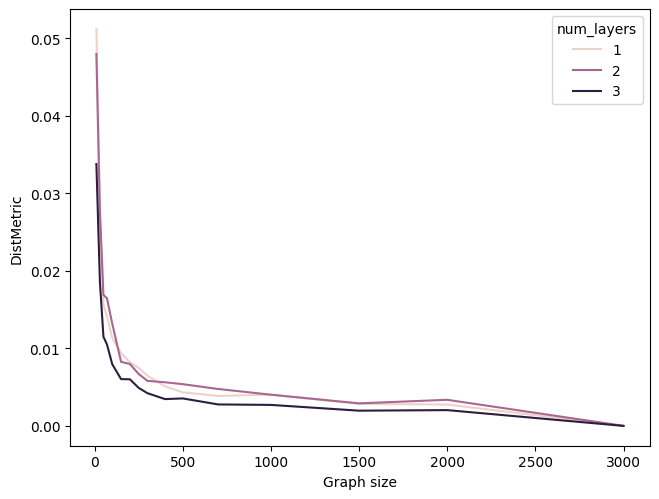

In [28]:
sns.lineplot(y='norm_result', x='graph_dim', data=gcn_df, hue='num_layers')
plt.tight_layout(pad=0.)
plt.xlabel('Graph size')
plt.ylabel('DistMetric')
plt.savefig(f'{images_dir}/gcn_norm_diff.pdf', format='pdf', bbox_inches='tight')

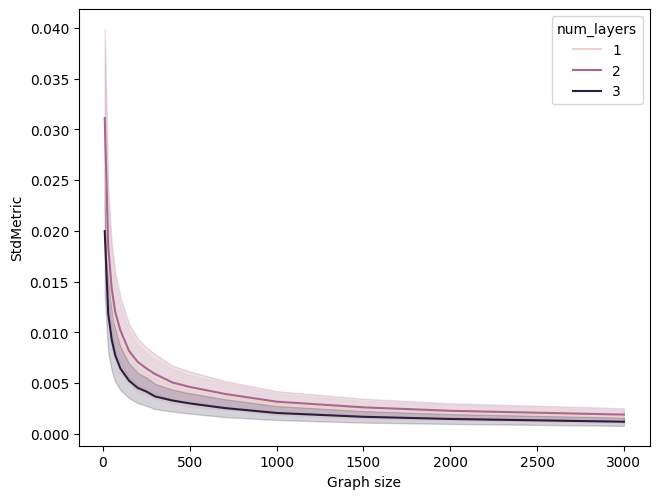

In [29]:
d = []
for _, line in gcn_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(data=df, y='std_value', x='graph_dim', hue='num_layers', errorbar='sd');
plt.tight_layout(pad=0.)
plt.xlabel('Graph size')
plt.ylabel('StdMetric')
plt.savefig(f'{images_dir}/gcn_std_result.pdf', format='pdf', bbox_inches='tight')

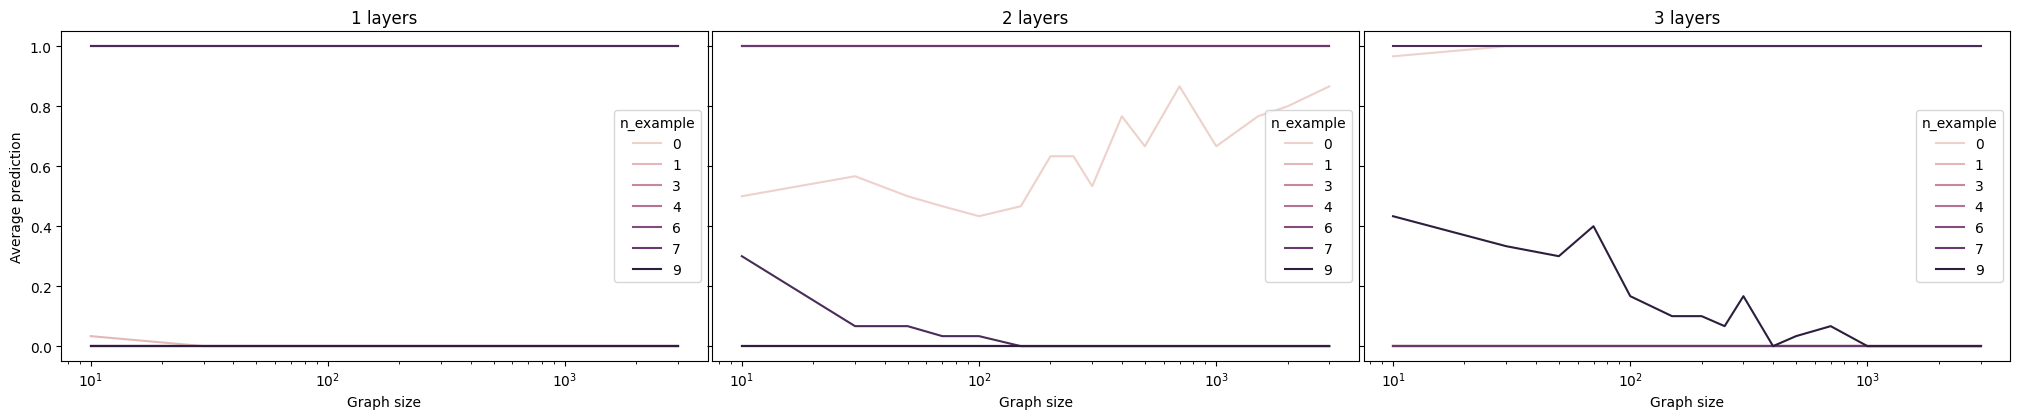

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
for i, l in enumerate(NUM_LAYERS):
  df = gcn_results[(gcn_results['num_layers'] == l)]
  sns.lineplot(ax=axs[i], y='result', x='graph_dim', hue='n_example', data=df)
  axs[i].set_xscale('log')
  axs[i].set_title(f'{l} layers')
  axs[i].set_xlabel('Graph size')
  axs[i].set_ylabel('Average prediction')
plt.tight_layout(pad=0.)
plt.savefig(f'{images_dir}/gcn_layers.pdf', format='pdf', bbox_inches='tight')

### Mean GNN model

In [32]:
meangnn_results = get_results(model=MeanGNN,
                              embedding_dim=EMBEDDING_DIM,
                              rate=RATE,
                              num_layers=NUM_LAYERS,
                              num_models=10,
                              graph_dim_list=GRAPH_DIM,
                              graphs=GRAPHS,
                              num_examples=NUM_EXAMPLES)
meangnn_results.head()

,graph_dim,embedding_dim,rate,num_layers,n_example,std,result,raw_result
0,10,128,0.5,1,0,"[3.726939, 3.7357216, 0.0, 0.0, 3.4683511, 2.4...",1.0,"[33.65515, 5.580911, 0.0, 0.0, 10.864411, 12.7..."
1,30,128,0.5,1,0,"[1.6817284, 1.7144264, 0.0, 0.0, 1.9219234, 1....",1.0,"[34.232803, 4.146816, 0.0, 0.0, 11.196232, 12...."
2,50,128,0.5,1,0,"[1.4245262, 1.7736902, 0.0, 0.0, 1.5367522, 1....",1.0,"[33.810226, 3.703185, 0.0, 0.0, 12.229036, 12...."
3,70,128,0.5,1,0,"[0.8383981, 1.2533066, 0.0, 0.0, 1.4694835, 0....",1.0,"[34.004818, 3.6496, 0.0, 0.0, 12.016442, 12.32..."
4,100,128,0.5,1,0,"[0.83246183, 0.9693802, 0.0, 0.0, 1.0430621, 0...",1.0,"[34.042843, 3.8655472, 0.0, 0.0, 12.262173, 12..."


In [33]:
mean_df = meangnn_results.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (mean_df['rate'] == r) & (mean_df['embedding_dim'] == dim) & (mean_df['num_layers'] == l)
      mean_df.loc[mask, 'norm_result'] = mean_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (mean_df.loc[(mask & (mean_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

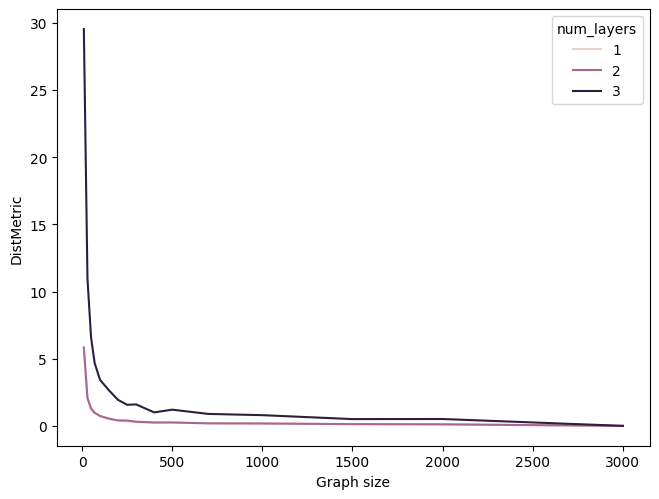

In [34]:
sns.lineplot(y='norm_result', x='graph_dim', data=mean_df, hue='num_layers')
plt.tight_layout(pad=0.)
plt.xlabel('Graph size')
plt.ylabel('DistMetric')
plt.savefig(f'{images_dir}/meangnn_norm_result.pdf', format='pdf', bbox_inches='tight')

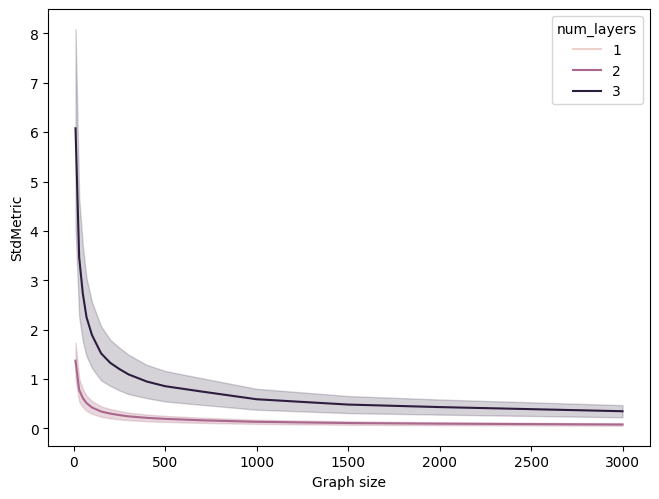

In [35]:
d = []
for _, line in mean_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(data=df, y='std_value', x='graph_dim', hue='num_layers', errorbar='sd');
plt.tight_layout(pad=0.)
plt.xlabel('Graph size')
plt.ylabel('StdMetric')
plt.savefig(f'{images_dir}/mean_gnn_std_result.pdf', format='pdf', bbox_inches='tight')

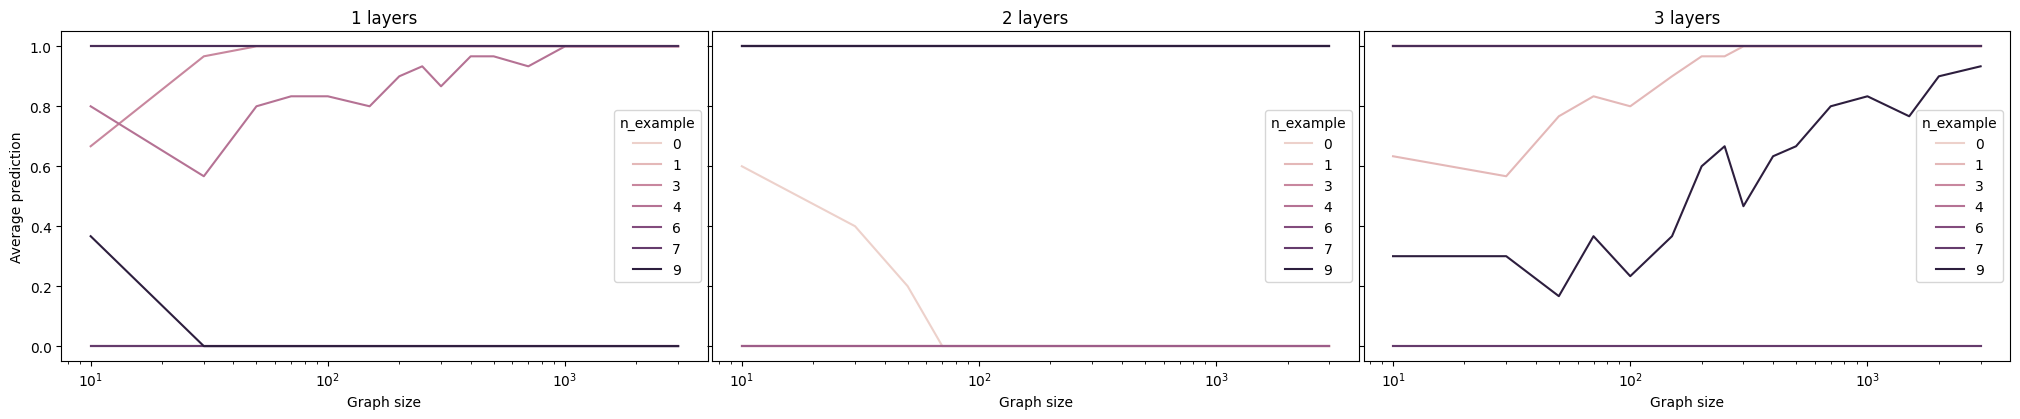

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
for i, l in enumerate(NUM_LAYERS):
  df = meangnn_results[(meangnn_results['num_layers'] == l)]
  sns.lineplot(ax=axs[i], y='result', x='graph_dim', hue='n_example', data=df)
  axs[i].set_xscale('log')
  axs[i].set_title(f'{l} layers')
  axs[i].set_xlabel('Graph size')
  axs[i].set_ylabel('Average prediction')
plt.tight_layout(pad=0.)
plt.savefig(f'{images_dir}/mean_gnn_layers.pdf', format='pdf', bbox_inches='tight')

## Experiment 2: PPI Dataset

In [38]:
dataset = datasets.PPI(
    root="./",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Extracting ./ppi.zip
Processing...


Data(x=[44906, 50], edge_index=[2, 1226368], y=[44906, 121])


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:293: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


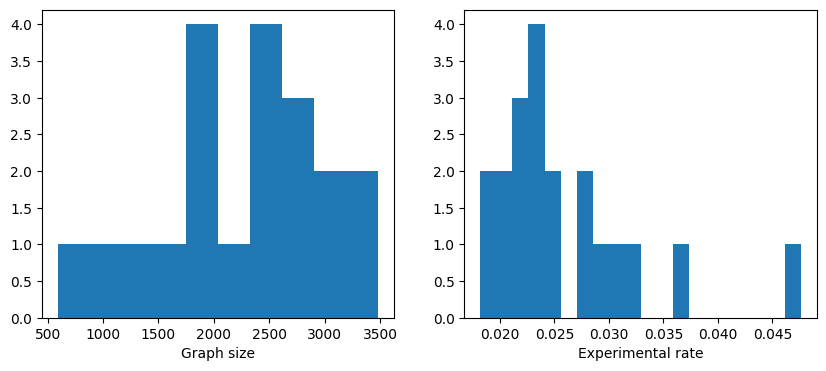

In [39]:
num_nodes_list = []
edges_rate = []
ppi_graphs = [[] for _ in range(10)]
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
for data in dataset:
  num_nodes_list.append(len(data.x))
  max_edges = len(data.x)*(len(data.x)-1)/2
  edges_rate.append(data.edge_index.shape[1]/max_edges)
  ppi_graphs[(len(data.x)-500)//300].append(data)
axs[0].hist(num_nodes_list, bins=10);
axs[1].hist(edges_rate, bins=20)
axs[0].set_xlabel('Graph size')
axs[1].set_xlabel('Experimental rate')
plt.savefig(f'{images_dir}/ppi_hist.pdf')
plt.show()

In [40]:
gcn_results_realworlddata = pd.DataFrame()
for r in RATE:
    for l in NUM_LAYERS:
      for num_model in range(10):
        graph_model = GCN(input_dim=50,
                          hid_dim=128,
                          output_dim=1,
                          n_graph_layers=l,
                          n_linear_layers=2,
                          pooling_fn='mean').to(device)
        graph_model.eval()
        for i, graphs in enumerate(ppi_graphs):
          for data in graphs:
              data=data.to(device)
              with torch.no_grad():
                output, raw_output = graph_model(data.x, data.edge_index, intermediate_res=True)
              results = int(output > 0.5)
              raw_results = raw_output.mean().item()
              result = pd.DataFrame({'graph_dim': [len(data.x)],
                                    'embedding_dim': [dim],
                                    'rate': [r],
                                    'num_layers': [l],
                                    'n_example': [num_model],
                                    'result': [results],
                                    'raw_result': [raw_results]})
              gcn_results_realworlddata = pd.concat([gcn_results_realworlddata, result], ignore_index=True)
gcn_results_realworlddata.head()

,graph_dim,embedding_dim,rate,num_layers,n_example,result,raw_result
0,591,128,0.5,1,0,0,0.038289
1,1021,128,0.5,1,0,0,0.028376
2,1377,128,0.5,1,0,0,0.026271
3,1578,128,0.5,1,0,0,0.024070
4,1767,128,0.5,1,0,0,0.040039


In [41]:
gcn_realworlddata_df = gcn_results_realworlddata.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (gcn_realworlddata_df['rate'] == r) & (gcn_realworlddata_df['embedding_dim'] == dim) & (gcn_realworlddata_df['num_layers'] == l)
      gcn_realworlddata_df.loc[mask, 'norm_result'] = gcn_realworlddata_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (gcn_realworlddata_df.loc[(mask & (gcn_realworlddata_df['graph_dim'] == max(num_nodes_list))), 'raw_result']).values[0]))

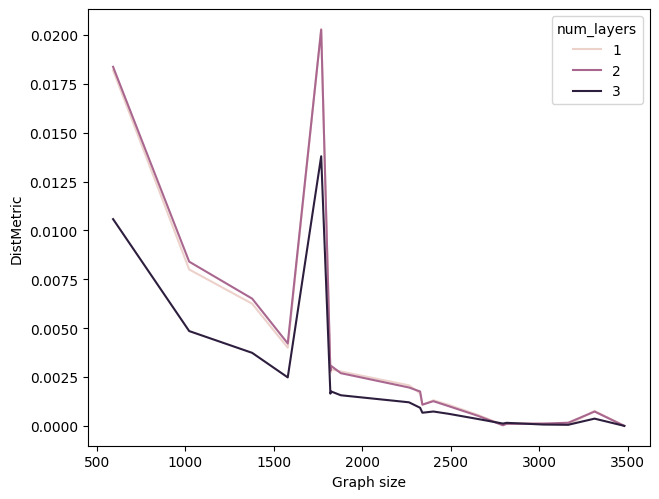

In [42]:
sns.lineplot(y='norm_result', x='graph_dim', data=gcn_realworlddata_df, hue='num_layers')
plt.tight_layout(pad=0.)
plt.xlabel('Graph size')
plt.ylabel('DistMetric')
plt.savefig(f'{images_dir}/gcn_ppi_norm_result.pdf', format='pdf', bbox_inches='tight')

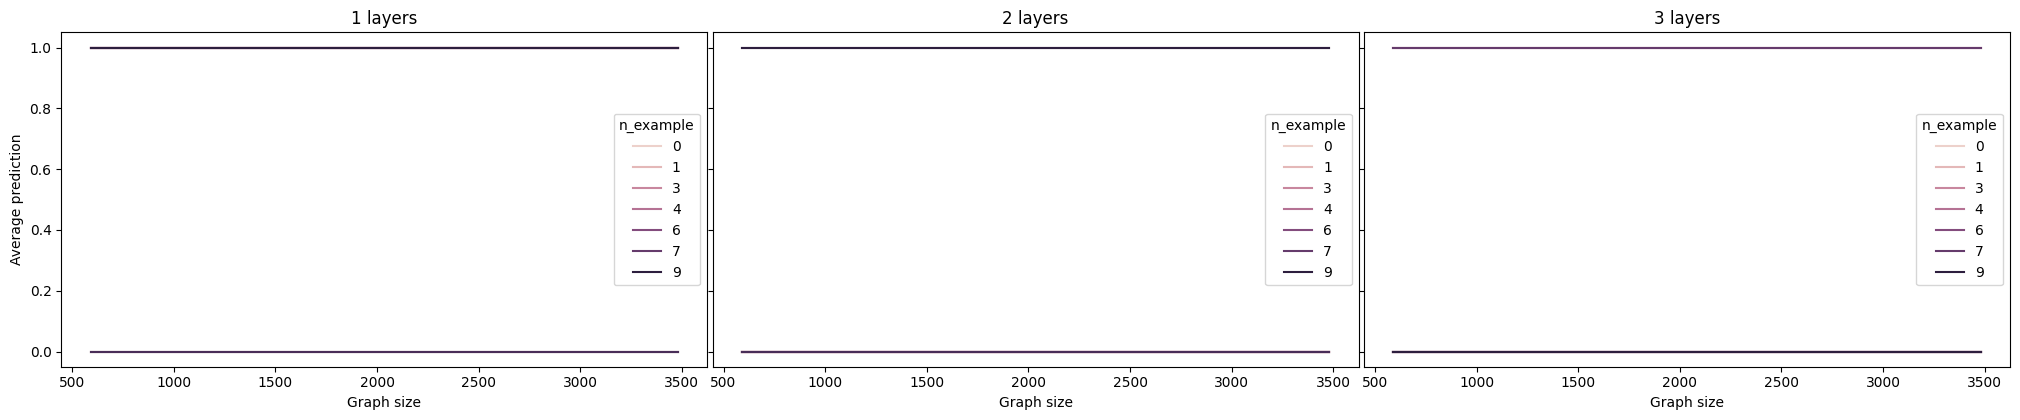

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
for i, l in enumerate(NUM_LAYERS):
  df = gcn_results_realworlddata[(gcn_results_realworlddata['num_layers'] == l)]
  sns.lineplot(ax=axs[i], y='result', x='graph_dim', hue='n_example', data=df)
  axs[i].set_title(f'{l} layers')
  axs[i].set_xlabel('Graph size')
  axs[i].set_ylabel('Average prediction')
plt.tight_layout(pad=0.)
plt.savefig(f'{images_dir}/gcn_ppi_layers.pdf', format='pdf', bbox_inches='tight')

## Experiment 3: GAT and GIN models

In [44]:
gat_df = get_results(model=GAT,
                    embedding_dim=EMBEDDING_DIM,
                    rate=RATE,
                    num_layers=NUM_LAYERS,
                    num_models=10,
                    graph_dim_list=None,
                    graphs=GRAPHS,
                    num_examples=NUM_EXAMPLES,
                    pooling_fn='mean')
gin_df = get_results(model=GIN,
                    embedding_dim=EMBEDDING_DIM,
                    rate=RATE,
                    num_layers=NUM_LAYERS,
                    num_models=10,
                    graph_dim_list=None,
                    graphs=GRAPHS,
                    num_examples=NUM_EXAMPLES,
                    pooling_fn='mean')

In [45]:
# GAT
res_gat_df = gat_df.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])['raw_result'].mean().reset_index()
res_gat_df['std_result'] = (gat_df.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])['raw_result'].apply(lambda x: np.stack(x).std(axis=0)).reset_index())['raw_result']
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (res_gat_df['rate'] == r) & (res_gat_df['embedding_dim'] == dim) & (res_gat_df['num_layers'] == l)
      res_gat_df.loc[mask, 'norm_result'] = res_gat_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (res_gat_df.loc[(mask & (res_gat_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))
# GIN
res_gin_df = gin_df.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])['raw_result'].mean().reset_index()
res_gin_df['std_result'] = (gin_df.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])['raw_result'].apply(lambda x: np.stack(x).std(axis=0)).reset_index())['raw_result']
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (res_gin_df['rate'] == r) & (res_gin_df['embedding_dim'] == dim) & (res_gin_df['num_layers'] == l)
      res_gin_df.loc[mask, 'norm_result'] = res_gin_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (res_gin_df.loc[(mask & (res_gin_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

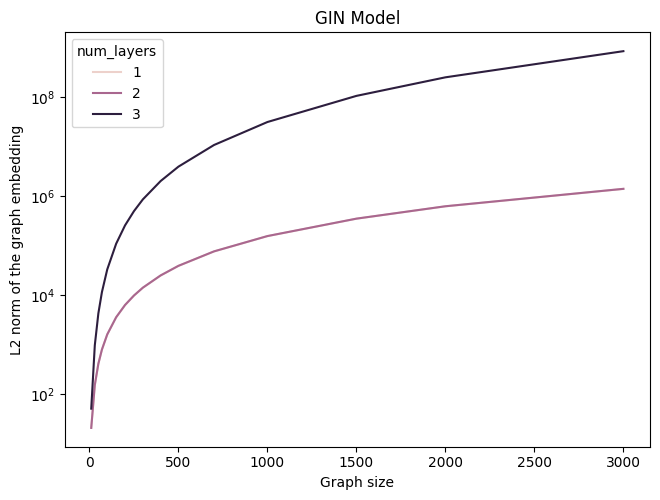

In [46]:
res_gin_df['raw_result'] = res_gin_df['raw_result'].apply(np.linalg.norm)
sns.lineplot(y='raw_result', x='graph_dim', hue='num_layers', data=res_gin_df)
plt.yscale('log')
plt.xlabel('Graph size')
plt.ylabel('L2 norm of the graph embedding')
plt.title('GIN Model')
plt.tight_layout(pad=0.)
plt.savefig(f'{images_dir}/gin_norm_result.pdf', format='pdf', bbox_inches='tight')

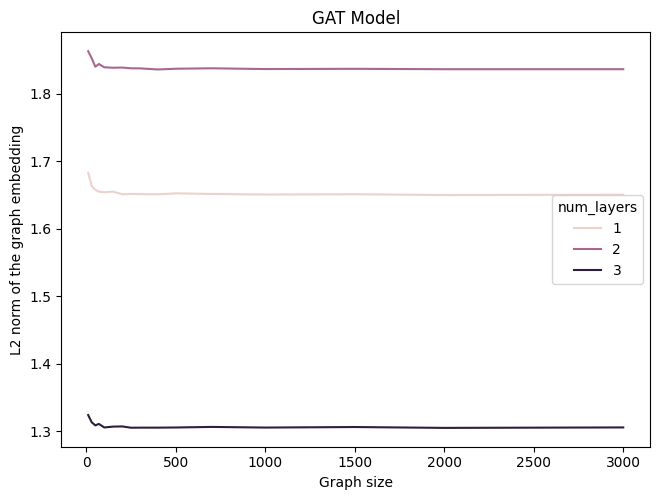

In [47]:
res_gat_df['raw_result'] = res_gat_df['raw_result'].apply(np.linalg.norm)
sns.lineplot(y='raw_result', x='graph_dim', hue="num_layers", data=res_gat_df)
plt.title('GAT Model')
plt.xlabel('Graph size')
plt.ylabel('L2 norm of the graph embedding')
plt.tight_layout(pad=0.)
plt.savefig(f'{images_dir}/gat_norm_result.pdf', format='pdf', bbox_inches='tight')

In [48]:
gat_res_df = gat_df.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (gat_res_df['rate'] == r) & (gat_res_df['embedding_dim'] == dim) & (gat_res_df['num_layers'] == l)
      gat_res_df.loc[mask, 'norm_result'] = gat_res_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (gat_res_df.loc[(mask & (gat_res_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

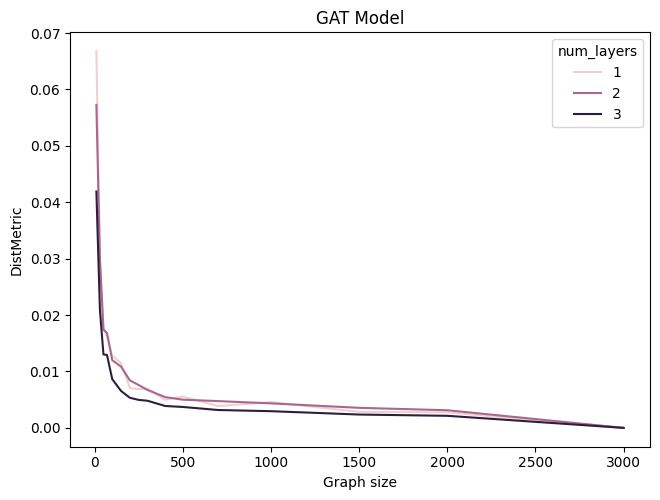

In [49]:
plt.tight_layout(pad=0)
sns.lineplot(y='norm_result', x='graph_dim', data=gat_res_df, hue="num_layers").set(title="GAT Model");
plt.xlabel('Graph size')
plt.ylabel('DistMetric')
plt.tight_layout(pad=0.)
plt.savefig(f'{images_dir}/gat_norm_result.pdf', format='pdf', bbox_inches='tight')

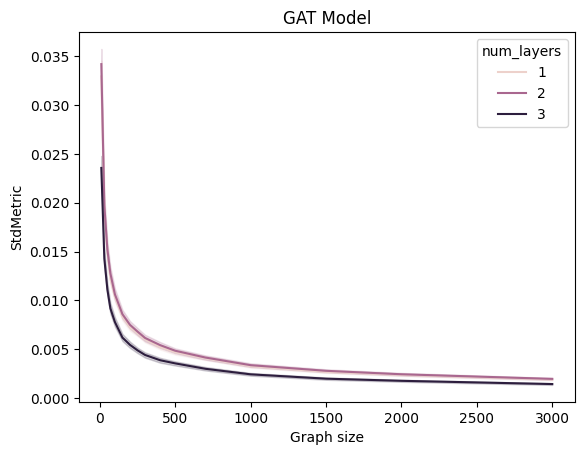

In [50]:
d = []
for _, line in gat_res_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(data=df, y='std_value', x='graph_dim', hue="num_layers").set(title='GAT Model');
plt.xlabel('Graph size')
plt.ylabel('StdMetric')
plt.savefig(f'{images_dir}/gat_std_result.pdf', format='pdf', bbox_inches='tight')

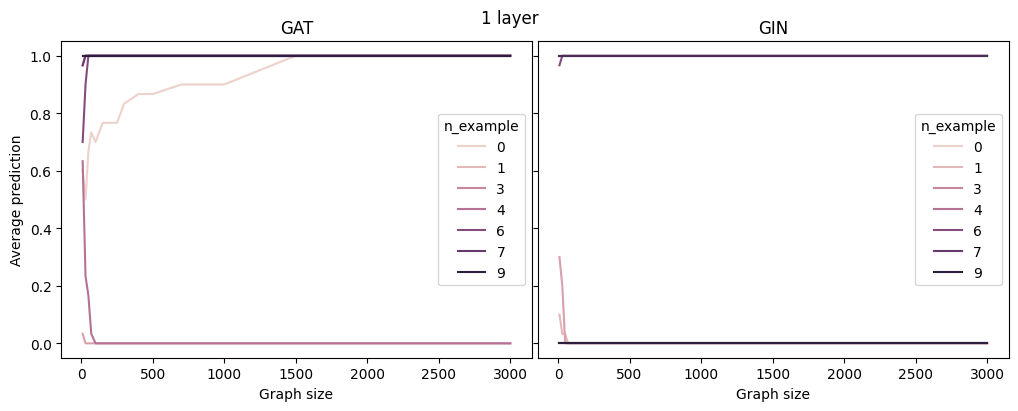

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.lineplot(ax=axs[0], y='result', x='graph_dim', hue='n_example', data=gat_df[gat_df['num_layers'] == 1])
axs[0].set_title(f'GAT')
axs[0].set_xlabel('Graph size')
axs[0].set_ylabel('Average prediction')
sns.lineplot(ax=axs[1], y='result', x='graph_dim', hue='n_example', data=gin_df[gin_df['num_layers'] == 1])
axs[1].set_title(f'GIN')
axs[1].set_xlabel('Graph size')
axs[1].set_ylabel('Average prediction')
fig.suptitle('1 layer')
plt.tight_layout(pad=0.)

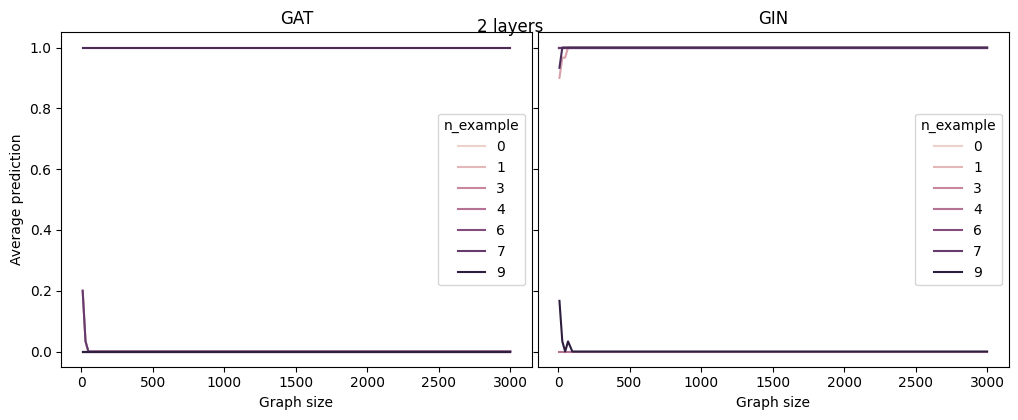

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.lineplot(ax=axs[0], y='result', x='graph_dim', hue='n_example', data=gat_df[gat_df['num_layers'] == 2])
axs[0].set_title(f'GAT')
axs[0].set_xlabel('Graph size')
axs[0].set_ylabel('Average prediction')
sns.lineplot(ax=axs[1], y='result', x='graph_dim', hue='n_example', data=gin_df[gin_df['num_layers'] == 2])
axs[1].set_title(f'GIN')
axs[1].set_xlabel('Graph size')
axs[1].set_ylabel('Average prediction')
plt.tight_layout(pad=0.)
fig.suptitle('2 layers')
plt.savefig(f'{images_dir}/various_models.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 0.98, '3 layers')

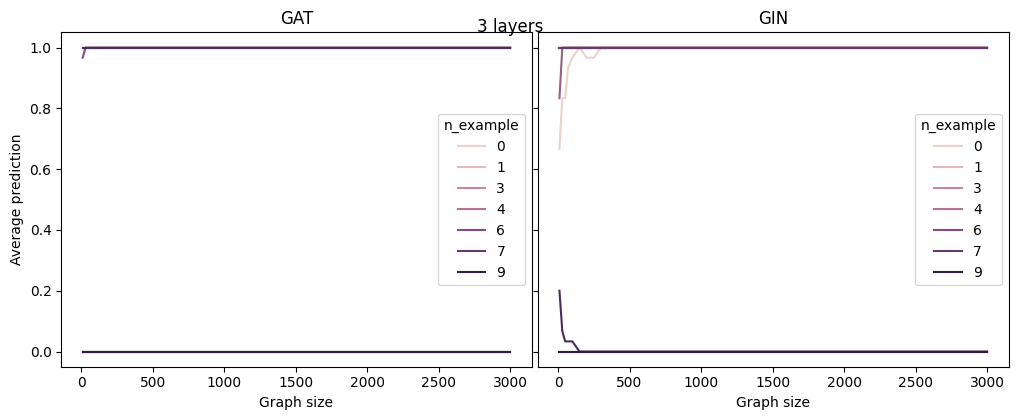

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.lineplot(ax=axs[0], y='result', x='graph_dim', hue='n_example', data=gat_df[gat_df['num_layers'] == 3])
axs[0].set_title(f'GAT')
axs[0].set_xlabel('Graph size')
axs[0].set_ylabel('Average prediction')
sns.lineplot(ax=axs[1], y='result', x='graph_dim', hue='n_example', data=gin_df[gin_df['num_layers'] == 3])
axs[1].set_title(f'GIN')
axs[1].set_xlabel('Graph size')
axs[1].set_ylabel('Average prediction')
plt.tight_layout(pad=0.)
fig.suptitle('3 layers')
# plt.savefig(f'{images_dir}/various_models.pdf', format='pdf', bbox_inches='tight')

## Additional experiments

Additional experiments run that are not presented in the mini-project report.

### Initialisation distribution

In [57]:
NUM_LAYERS = [1, 2, 3]

In [58]:
normal_meangnn_results = get_results(model=MeanGNN,
                                    embedding_dim=EMBEDDING_DIM,
                                    rate=RATE,
                                    num_layers=NUM_LAYERS,
                                    num_models=10,
                                    graph_dim_list=GRAPH_DIM,
                                    graphs=GRAPHS,
                                    num_examples=NUM_EXAMPLES,
                                    feature_distr='normal')
normal_meangnn_results.head()

,graph_dim,embedding_dim,rate,num_layers,n_example,std,result,raw_result
0,10,128,0.5,1,0,"[0.0, 2.1875262, 2.2324407, 1.7652957, 1.91236...",0.966667,"[0.0, 3.0483556, 12.177166, 1.3431252, 1.51911..."
1,30,128,0.5,1,0,"[0.0, 1.1378934, 1.2211143, 0.2439656, 0.35506...",1.000000,"[0.0, 1.4599916, 10.242114, 0.08362815, 0.0986..."
2,50,128,0.5,1,0,"[0.0, 0.9408052, 1.1024687, 0.048241466, 0.441...",1.000000,"[0.0, 1.1485842, 9.688509, 0.013533593, 0.0821..."
3,70,128,0.5,1,0,"[0.0, 0.8935468, 0.73783743, 0.0053849393, 0.0...",1.000000,"[0.0, 0.85625196, 9.624012, 0.0009999581, 0.0,..."
4,100,128,0.5,1,0,"[0.0, 0.82965285, 0.88277406, 0.0, 0.0, 0.6815...",1.000000,"[0.0, 0.89457357, 9.598111, 0.0, 0.0, 3.461400..."


In [59]:
normal_mean_df = normal_meangnn_results.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (normal_mean_df['rate'] == r) & (normal_mean_df['embedding_dim'] == dim) & (normal_mean_df['num_layers'] == l)
      normal_mean_df.loc[mask, 'norm_result'] = normal_mean_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (normal_mean_df.loc[(mask & (normal_mean_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

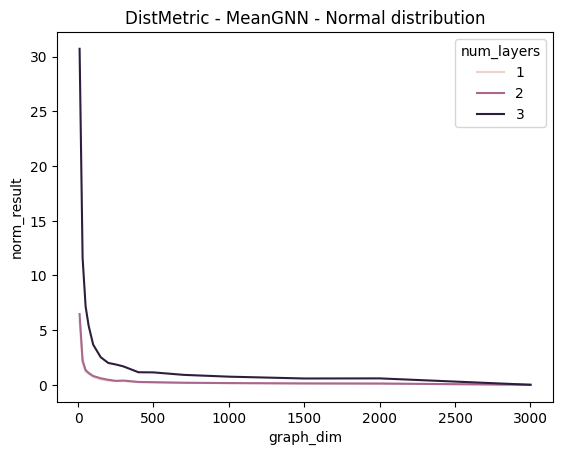

In [64]:
sns.lineplot(y='norm_result', x='graph_dim', data=normal_mean_df, hue='num_layers').set(title="DistMetric - MeanGNN - Normal distribution");
# plt.savefig(f'{images_dir}/normal_meangnn_norm_result.pdf')

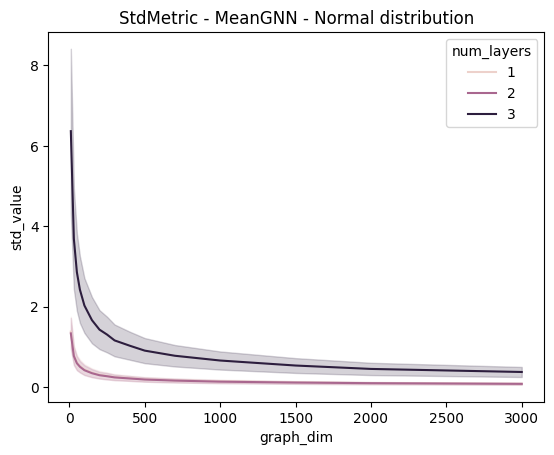

In [66]:
d = []
for _, line in normal_mean_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(data=df, y='std_value', x='graph_dim', hue='num_layers', errorbar='sd').set(title='StdMetric - MeanGNN - Normal distribution');
# plt.savefig(f'{images_dir}/normal_meangnn_std_result.pdf')

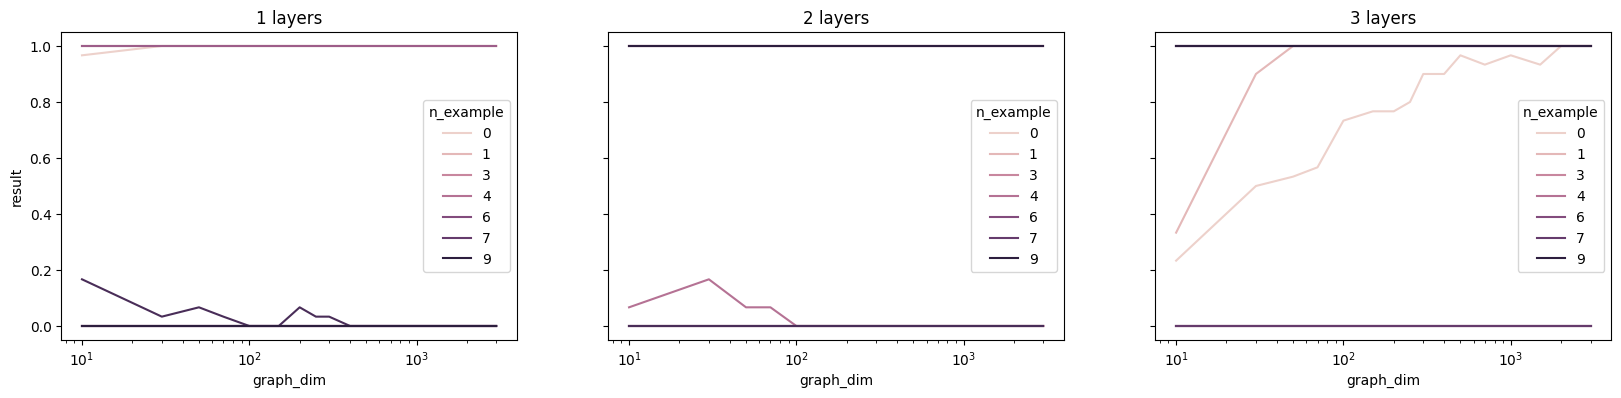

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
for i, l in enumerate(NUM_LAYERS):
  df = normal_meangnn_results[(normal_meangnn_results['num_layers'] == l)]
  sns.lineplot(ax=axs[i], y='result', x='graph_dim', hue='n_example', data=df)
  axs[i].set_xscale('log')
  axs[i].set_title(f'{l} layers')
plt.savefig(f'{images_dir}/normal_mean_gnn_layers.pdf')

In [67]:
exp_meangnn_results = get_results(model=MeanGNN,
                                    embedding_dim=EMBEDDING_DIM,
                                    rate=RATE,
                                    num_layers=NUM_LAYERS,
                                    num_models=10,
                                    graph_dim_list=GRAPH_DIM,
                                    graphs=GRAPHS,
                                    num_examples=NUM_EXAMPLES,
                                    feature_distr='exponential')
exp_meangnn_results.head()

,graph_dim,embedding_dim,rate,num_layers,n_example,std,result,raw_result
0,10,128,0.5,1,0,"[0.043800823, 3.3639126, 2.623222, 0.0, 2.9317...",0.633333,"[0.011447427, 6.5258603, 20.732359, 0.0, 11.45..."
1,30,128,0.5,1,0,"[0.0, 1.8229192, 1.6100483, 0.0, 1.5198848, 0....",0.433333,"[0.0, 5.036067, 21.079838, 0.0, 13.4419565, 0...."
2,50,128,0.5,1,0,"[0.0, 1.5315018, 1.230181, 0.0, 1.0750786, 0.2...",0.666667,"[0.0, 4.827261, 20.262884, 0.0, 13.694446, 0.1..."
3,70,128,0.5,1,0,"[0.0, 1.3126186, 1.2374505, 0.0, 1.0259279, 0....",0.666667,"[0.0, 4.4940777, 20.156895, 0.0, 13.489471, 0...."
4,100,128,0.5,1,0,"[0.0, 1.3261675, 0.97959584, 0.0, 0.96373594, ...",0.666667,"[0.0, 4.4802866, 19.675692, 0.0, 13.775697, 0...."


In [68]:
exp_mean_df = exp_meangnn_results.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (exp_mean_df['rate'] == r) & (exp_mean_df['embedding_dim'] == dim) & (exp_mean_df['num_layers'] == l)
      exp_mean_df.loc[mask, 'norm_result'] = exp_mean_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (exp_mean_df.loc[(mask & (exp_mean_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

[Text(0.5, 1.0, 'DistMetric - MeanGNN - Exponential distribution')]

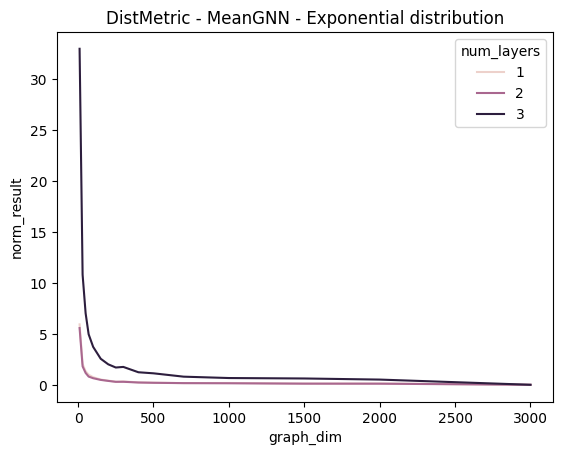

In [70]:
sns.lineplot(y='norm_result', x='graph_dim', data=exp_mean_df, hue='num_layers').set(title="DistMetric - MeanGNN - Exponential distribution")
# plt.savefig(f'{images_dir}/exp_meangnn_norm_result.pdf')

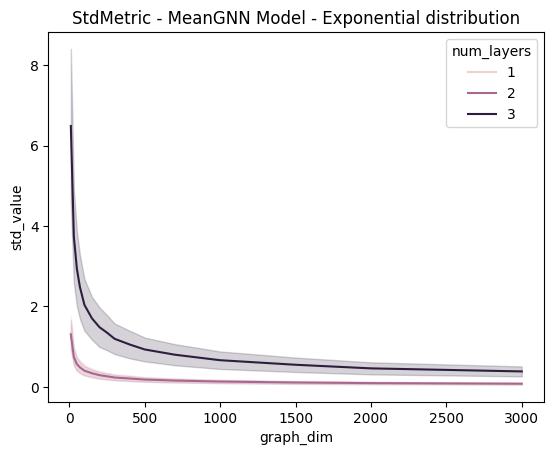

In [72]:
d = []
for _, line in exp_mean_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(data=df, y='std_value', x='graph_dim', hue='num_layers', errorbar='sd').set(title='StdMetric - MeanGNN Model - Exponential distribution');
# plt.savefig(f'{images_dir}/exp_meangnn_std_result.pdf')

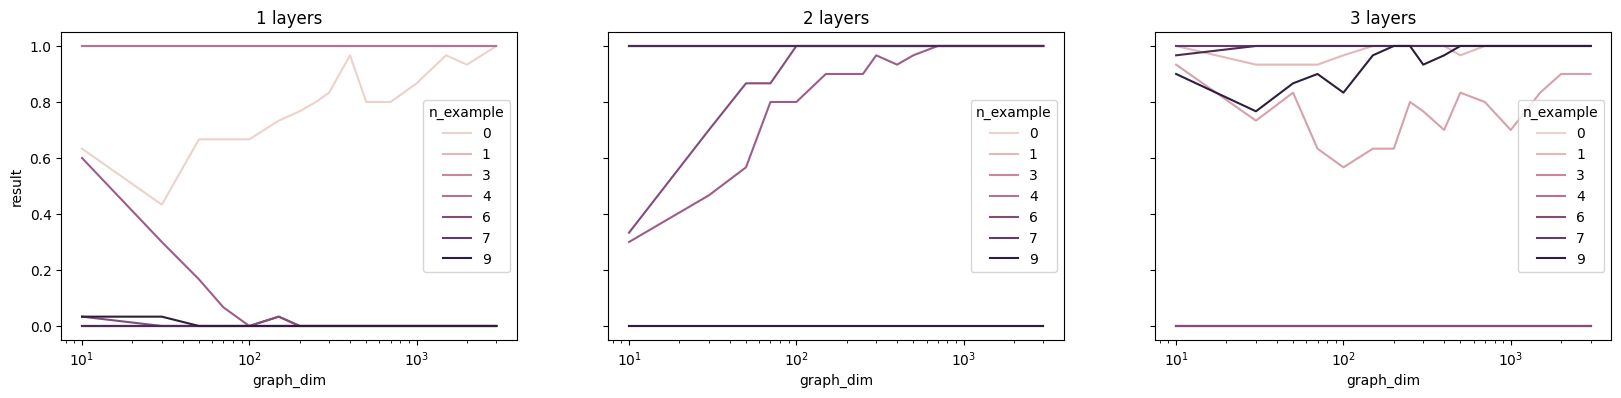

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
for i, l in enumerate(NUM_LAYERS):
  df = exp_meangnn_results[(exp_meangnn_results['num_layers'] == l)]
  sns.lineplot(ax=axs[i], y='result', x='graph_dim', hue='n_example', data=df)
  axs[i].set_xscale('log')
  axs[i].set_title(f'{l} layers')
plt.savefig(f'{images_dir}/exp_mean_gnn_layers.pdf')

### Embedding dimension

In [94]:
NUM_LAYERS = [1]
EMBEDDING_DIM = [64, 128, 256]
RATE = [0.5]

In [95]:
gcn_emb_results = get_results(model=GCN,
                          embedding_dim=EMBEDDING_DIM,
                          rate=RATE,
                          num_layers=NUM_LAYERS,
                          num_models=10,
                          graph_dim_list=GRAPH_DIM,
                          num_examples=NUM_EXAMPLES)
gcn_emb_results.head()

,graph_dim,embedding_dim,rate,num_layers,n_example,std,result,raw_result
0,10,64,0.5,1,0,"[0.03312596, 0.041415628, 0.03649185, 0.0, 0.0...",1.0,"[0.058451124, 0.08245997, 0.27653703, 0.0, 0.1..."
1,30,64,0.5,1,0,"[0.024128547, 0.023333216, 0.028748306, 0.0, 0...",1.0,"[0.05104638, 0.10045678, 0.26404002, 0.0, 0.20..."
2,50,64,0.5,1,0,"[0.017242728, 0.022326797, 0.020127285, 0.0, 0...",1.0,"[0.057892922, 0.09905919, 0.25223237, 0.0, 0.2..."
3,70,64,0.5,1,0,"[0.015279194, 0.019238552, 0.019680165, 0.0, 0...",1.0,"[0.053544406, 0.09652387, 0.25781545, 0.0, 0.1..."
4,100,64,0.5,1,0,"[0.014585468, 0.015991613, 0.013988389, 0.0, 0...",1.0,"[0.05277884, 0.09632347, 0.26067448, 0.0, 0.19..."


In [96]:
gcn_emb_df = gcn_emb_results.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (gcn_emb_df['rate'] == r) & (gcn_emb_df['embedding_dim'] == dim) & (gcn_emb_df['num_layers'] == l)
      gcn_emb_df.loc[mask, 'norm_result'] = gcn_emb_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (gcn_emb_df.loc[(mask & (gcn_emb_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

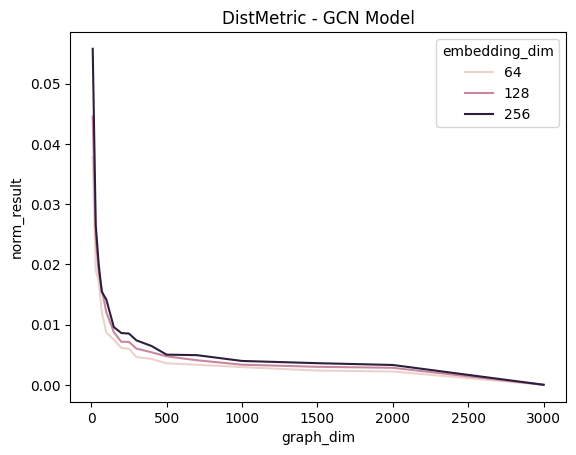

In [101]:
sns.lineplot(y='norm_result', x='graph_dim', data=gcn_emb_df, hue="embedding_dim").set(title="DistMetric - GCN Model");
# plt.savefig(f'{images_dir}/gcn_emb_norm_result.pdf')

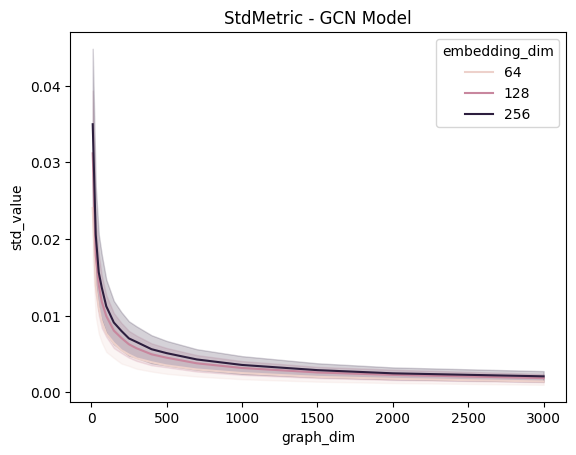

In [104]:
d = []
for _, line in gcn_emb_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'embedding_dim': line['embedding_dim'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(data=df, y='std_value', x='graph_dim', hue='embedding_dim', errorbar='sd').set(title='StdMetric - GCN Model');
# plt.savefig(f'{images_dir}/gcn_emb_std_result.pdf')

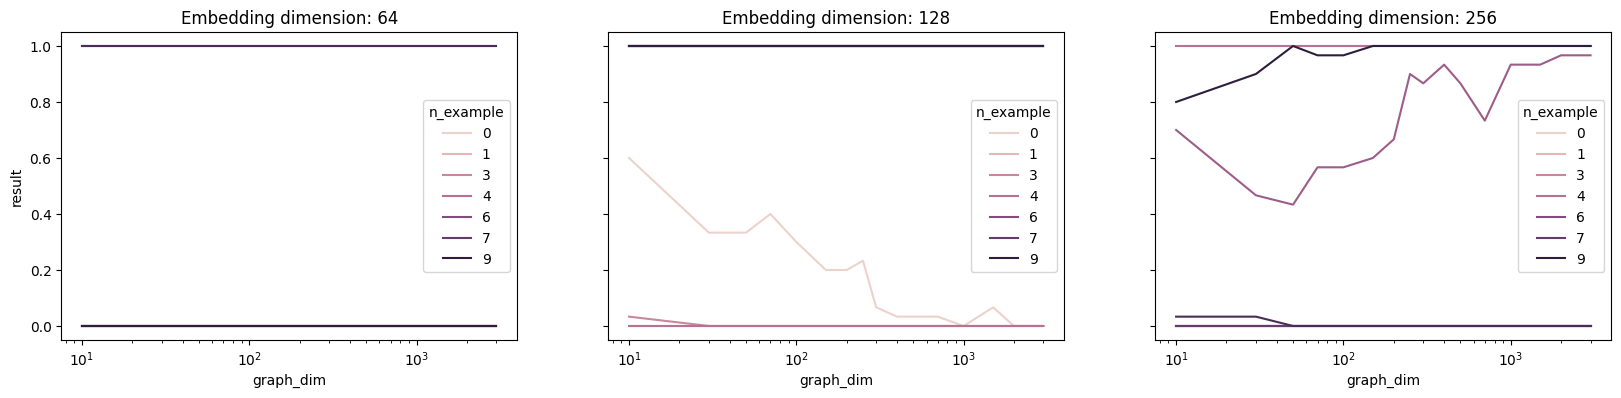

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
for i, dim in enumerate(EMBEDDING_DIM):
    df = gcn_emb_results[(gcn_emb_results['embedding_dim'] == dim)]
    sns.lineplot(ax=axs[i], y='result', x='graph_dim', hue='n_example', data=df)
    axs[i].set_title(f'Embedding dimension: {dim}')
    axs[i].set_xscale('log')
plt.savefig(f'{images_dir}/gcn_emb_results.pdf')

### Pooling function

In [106]:
NUM_LAYERS = [1, 2, 3]
EMBEDDING_DIM = [128]
RATE = [0.5]

In [107]:
gcn_results_max = get_results(model=GCN,
                              embedding_dim=EMBEDDING_DIM,
                              rate=RATE,
                              num_layers=NUM_LAYERS,
                              num_models=10,
                              graphs=GRAPHS,
                              graph_dim_list=None,
                              num_examples=NUM_EXAMPLES,
                              pooling_fn='max')
gcn_results_mean = get_results(model=GCN,
                              embedding_dim=EMBEDDING_DIM,
                              rate=RATE,
                              num_layers=NUM_LAYERS,
                              num_models=10,
                              graphs=GRAPHS,
                               graph_dim_list=None,
                              num_examples=NUM_EXAMPLES,
                              pooling_fn='mean')
gcn_results_sum = get_results(model=GCN,
                              embedding_dim=EMBEDDING_DIM,
                              rate=RATE,
                              num_layers=NUM_LAYERS,
                              num_models=10,
                              graphs=GRAPHS,
                              graph_dim_list=None,
                              num_examples=NUM_EXAMPLES,
                              pooling_fn='sum')

In [110]:
# Max pooling
max_df = gcn_results_max.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (max_df['rate'] == r) & (max_df['embedding_dim'] == dim) & (max_df['num_layers'] == l)
      max_df.loc[mask, 'norm_result'] = max_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (max_df.loc[(mask & (max_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))
# Mean pooling
mean_df = gcn_results_mean.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (mean_df['rate'] == r) & (mean_df['embedding_dim'] == dim) & (mean_df['num_layers'] == l)
      mean_df.loc[mask, 'norm_result'] = mean_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (mean_df.loc[(mask & (mean_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))
# Sum pooling
sum_df = gcn_results_sum.groupby(['embedding_dim', 'rate', 'num_layers', 'graph_dim'])[['raw_result', 'std']].mean().reset_index()
for l in NUM_LAYERS:
  for r in RATE:
    for dim in EMBEDDING_DIM:
      mask = (sum_df['rate'] == r) & (sum_df['embedding_dim'] == dim) & (sum_df['num_layers'] == l)
      sum_df.loc[mask, 'norm_result'] = sum_df.loc[mask, 'raw_result'].apply(lambda x: np.linalg.norm(x - (sum_df.loc[(mask & (sum_df['graph_dim'] == GRAPH_DIM[-1])), 'raw_result']).values[0]))

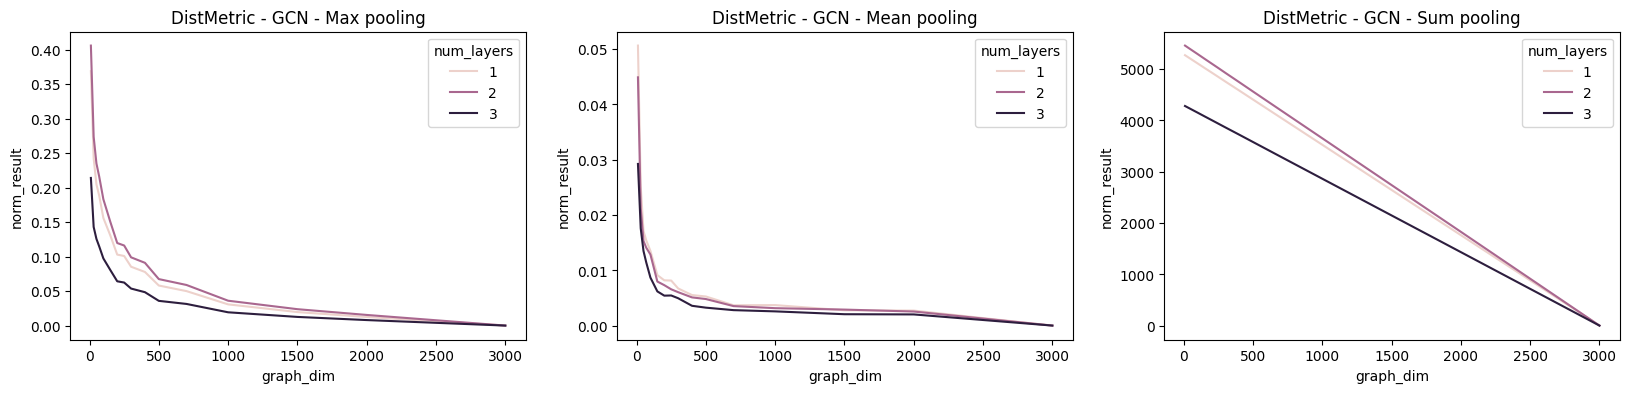

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
sns.lineplot(ax=axs[0], y='norm_result', x='graph_dim', data=max_df, hue="num_layers").set(title='DistMetric - GCN - Max pooling')
sns.lineplot(ax=axs[1], y='norm_result', x='graph_dim', data=mean_df, hue="num_layers").set(title='DistMetric - GCN - Mean pooling')
sns.lineplot(ax=axs[2], y='norm_result', x='graph_dim', data=sum_df, hue="num_layers").set(title='DistMetric - GCN - Sum pooling')
plt.show()
# plt.savefig(f'{images_dir}/pooling_norm.pdf')

[Text(0.5, 1.0, 'Graph Embedding norm - GCN Model with Sum Pooling')]

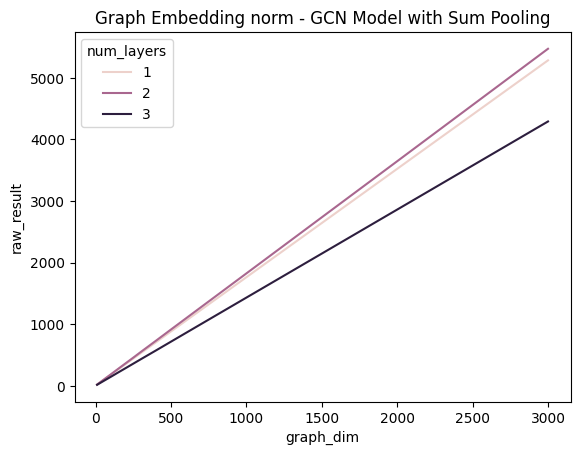

In [149]:
sum_df['raw_result'] = sum_df['raw_result'].apply(np.linalg.norm)
sns.lineplot(y='raw_result', x='graph_dim', data=sum_df, hue="num_layers").set(title='Graph Embedding norm - GCN Model with Sum Pooling')
# plt.savefig(f'{images_dir}/pooling_sum_result.pdf')

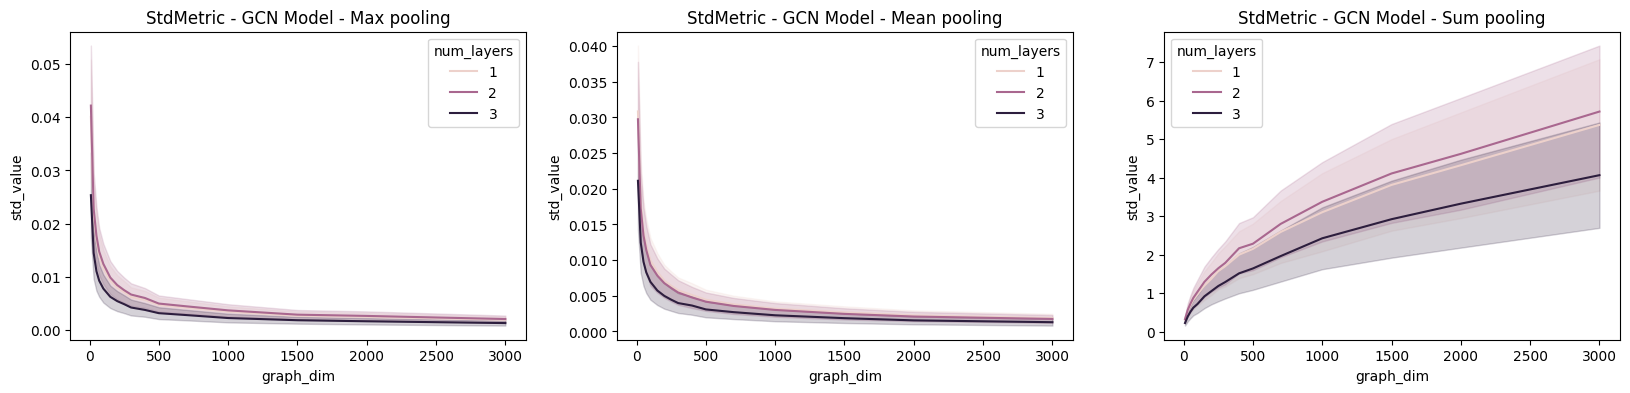

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
# Max pooling
d = []
for _, line in max_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(ax=axs[0], data=df, y='std_value', x='graph_dim', hue="num_layers", errorbar='sd').set(title='StdMetric - GCN Model - Max pooling')
# Mean pooling
d = []
for _, line in mean_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(ax=axs[1], data=df, y='std_value', x='graph_dim', hue="num_layers", errorbar='sd').set(title='StdMetric - GCN Model - Mean pooling')
# Sum pooling
d = []
for _, line in sum_df.iterrows():
  std_array = line['std']
  for i, elt in enumerate(std_array):
    d.append({'num_layers': line['num_layers'], 'std_value': elt, 'graph_dim': line['graph_dim']})
df = pd.DataFrame(d)
sns.lineplot(ax=axs[2], data=df, y='std_value', x='graph_dim', hue="num_layers", errorbar='sd').set(title='StdMetric - GCN Model - Sum pooling')
plt.show()
# plt.savefig(f'{images_dir}/pooling_std.pdf')

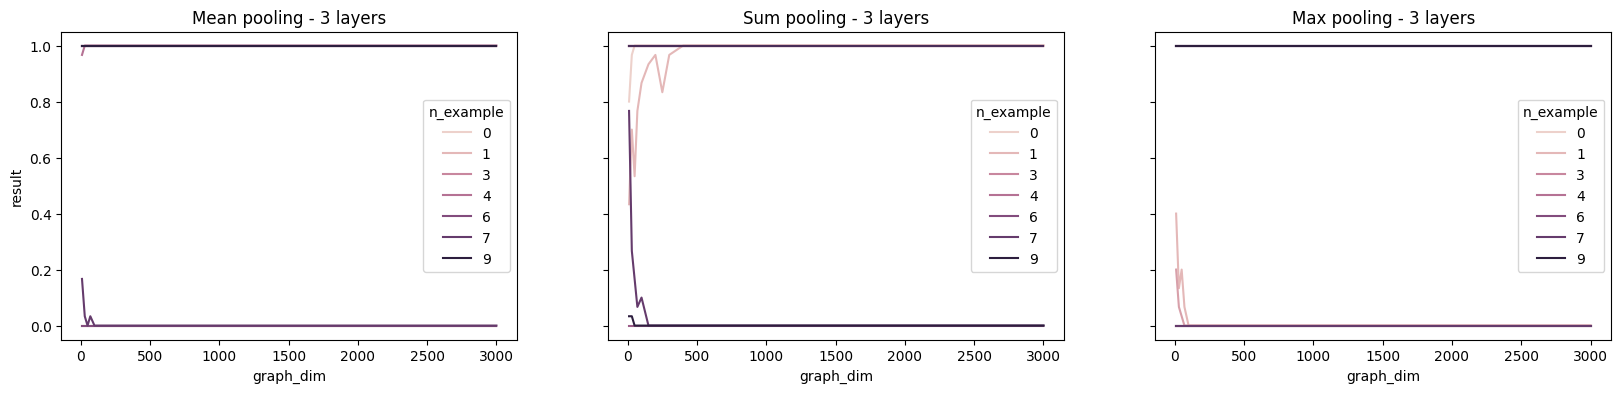

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)
sns.lineplot(ax=axs[0], y='result', x='graph_dim', hue='n_example', data=gcn_results_mean[gcn_results_mean['num_layers'] == 3])
axs[0].set_title(f'Mean pooling - 3 layers')
sns.lineplot(ax=axs[1], y='result', x='graph_dim', hue='n_example', data=gcn_results_sum[gcn_results_sum['num_layers'] == 3])
axs[1].set_title(f'Sum pooling - 3 layers')
sns.lineplot(ax=axs[2], y='result', x='graph_dim', hue='n_example', data=gcn_results_max[gcn_results_max['num_layers'] == 3])
axs[2].set_title(f'Max pooling - 3 layers')
plt.show()
# plt.savefig(f'{images_dir}/results_pooling.pdf')